In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0 --ignore-installed

### Import necessary modules:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from functools import reduce
from functions import prepare_image, extract_features
import os
import json
from PIL import Image

### Get a list of all hashtags

In [4]:
json_file_names = os.listdir('json_files')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

In [5]:
# remove '.DS_', '.ipynb_checkp'
non_hashtags = ['.DS_', '.ipynb_checkp']
for non_hashtag in non_hashtags:
    try:
        hashtags.remove(non_hashtag)
    except:
        pass # If we can't remove it, it's already gone
    
hashtags

['fitness',
 'selfie',
 'travel',
 'nature',
 'babies',
 'cars',
 'food',
 'architecture',
 'animals',
 'wedding']

In [6]:
hashtag_dfs = []
for hashtag in hashtags: 
    hashtag_dfs.append(pd.read_json(f'json_files/{hashtag}.json'))
df = reduce(lambda x, y: pd.concat([x, y]), hashtag_dfs)

In [7]:
full_list = pd.DataFrame.reset_index(df, drop=True)

In [8]:
full_list.tail()

,hashtags,image,image_local_name,post_link,search_hashtag
2995,"[#Wedding, #ido, #ianandwendytietheknot, #wedd...",https://scontent-sea1-1.cdninstagram.com/vp/29...,905a1d9c-b29d-44c7-ab5c-408c0b5d91ac.jpg,https://www.instagram.com/p/B0dcq0FBPQ3/,wedding
2996,"[#wedding, #mariages, #celebrantecuritiba, #ce...",https://scontent-sea1-1.cdninstagram.com/vp/bb...,6e424f02-d10e-42db-a233-9ce2724fb8a9.jpg,https://www.instagram.com/p/BwXbu7MgCTZ/,wedding
2997,"[#weddingring, #wedding, #shoes, #nancy, #sigm...",https://scontent-sea1-1.cdninstagram.com/vp/25...,ae49d2bb-95f7-4d16-9ee5-1603e97e6dd8.jpg,https://www.instagram.com/p/B0gwuc2icKv/,wedding
2998,"[#wedding, #standesamtgoetheallee, #retroweddi...",https://scontent-sea1-1.cdninstagram.com/vp/21...,9152a6d4-abda-4adf-87a4-7988dc4bb3ac.jpg,https://www.instagram.com/p/B0gwufzImAz/,wedding
2999,"[#kinalik, #gelinlik, #bursad, #wedding, #dama...",https://scontent-sea1-1.cdninstagram.com/vp/15...,09aaa471-2ed6-4ead-84db-e4aa6b0ece8f.jpg,https://www.instagram.com/p/B0gwubDhu6M/,wedding


### Resizing image to be used in tensorflow framework for Deep Feature Extraction

In [9]:
pics = []
for i, row in full_list.iterrows():
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path, where='local')
        pics.append({'pic': img, 'hashtag': hashtag, 'name': name})
    except:
        # If a file in the list isn't in 
        # storage, skip it and continue
        pass

In [10]:
type(pics[64]['pic'])

tensorflow.python.framework.ops.EagerTensor

W0829 16:42:13.443768 4639438272 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


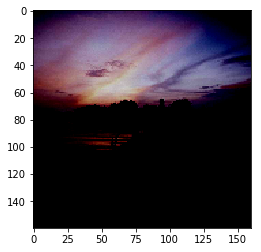

In [11]:
plt.imshow(pics[64]['pic']);

In [12]:
# add extracted deep features information to pics, make it a list of dictionaries

deep_features = list(map(extract_features, pics))

In [13]:
# confirm that the type of deep_features variable is a list

type(deep_features)

list

In [14]:
# train test split deep features: not used in the model, just in case needs to be used in the future

shuffle(deep_features)
train_size = int(len(deep_features) * .7)
train, test = deep_features[:train_size], deep_features[train_size:]

In [15]:
# check the first element of the train set

train[0]

{'pic': <tf.Tensor: id=35715, shape=(160, 160, 3), dtype=float32, numpy=
 array([[[ 0.42352945,  0.36078435,  0.23921573],
         [ 0.4294118 ,  0.34705886,  0.23333338],
         [ 0.42352945,  0.3411765 ,  0.21176475],
         ...,
         [ 0.4176471 ,  0.3666667 ,  0.25882357],
         [ 0.40196082,  0.354902  ,  0.24509808],
         [ 0.42549023,  0.3784314 ,  0.2686275 ]],
 
        [[ 0.38823533,  0.35294122,  0.22352946],
         [ 0.40980396,  0.38431376,  0.25098044],
         [ 0.45882356,  0.43921572,  0.31372553],
         ...,
         [ 0.5137255 ,  0.47450984,  0.3803922 ],
         [ 0.43529415,  0.3921569 ,  0.29803926],
         [ 0.40980396,  0.36274514,  0.2686275 ]],
 
        [[ 0.38431376,  0.3686275 ,  0.21960789],
         [ 0.454902  ,  0.454902  ,  0.32156867],
         [ 0.63529414,  0.64705884,  0.5352942 ],
         ...,
         [ 0.7490196 ,  0.7372549 ,  0.6431373 ],
         [ 0.49803925,  0.454902  ,  0.37254906],
         [ 0.42549023,  0.366

In [16]:
# look at the dictionary keys of the first element 

train[0].keys()

dict_keys(['pic', 'hashtag', 'name', 'deep_features'])

In [17]:
pic = train[0]

W0829 16:43:28.201241 4639438272 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


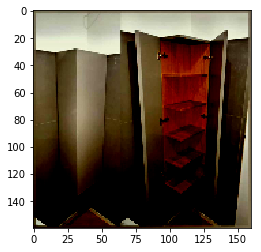

In [18]:
plt.imshow(pic['pic']);

In [19]:
pic['hashtag']

'architecture'

In [20]:
pic['deep_features'].shape

(1280,)

In [21]:
pic['pic'].shape

TensorShape([160, 160, 3])

In [22]:
df = pd.DataFrame(deep_features)

In [42]:
df.head()

,deep_features,hashtag,name,pic
0,"[0.9293431, 0.1402303, 0.072359845, 0.0, 0.055...",architecture,c9ac3a4a-312c-41e9-9f57-3792ecd572bd.jpg,"(((tf.Tensor(0.42352945, shape=(), dtype=float..."
1,"[0.03928654, 0.0, 0.0, 0.0, 0.004006176, 0.014...",babies,b3c53d46-1c6f-4a59-aa23-1227058757cf.jpg,"(((tf.Tensor(-0.17058823, shape=(), dtype=floa..."
2,"[0.0, 0.34763816, 0.03274338, 0.041628875, 2.3...",architecture,4792c02b-97cf-44a9-a039-e544f45fabbc.jpg,"(((tf.Tensor(-1.0, shape=(), dtype=float32), t..."
3,"[1.0387872, 0.0, 0.32377335, 1.1046413, 0.0282...",babies,e36ad2c2-5d2b-49d3-beb9-0dbac4bab00c.jpg,"(((tf.Tensor(0.49803925, shape=(), dtype=float..."
4,"[0.0, 0.0, 0.0, 0.41445747, 0.116170846, 0.234...",food,cdc75bd4-46f9-4a37-ab9b-1a0a6333e68c.jpg,"(((tf.Tensor(-0.20588234, shape=(), dtype=floa..."


In [43]:
filepath = "pkl_files/df_deep_features.pkl"
if os.path.exists(filepath):
    df.to_pickle(filepath)

## ALS Model

In [25]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel

In [26]:
spark = SparkSession.builder.master('local').getOrCreate()

In [27]:
# Train test split full_list. Not used in the model. Use code when necessary.
from sklearn.model_selection import train_test_split

train, test = train_test_split(full_list, test_size=0.2)

In [28]:
train.head()

,hashtags,image,image_local_name,post_link,search_hashtag
676,"[#children, #travel, #danish, #copenhagen, #bo...",https://scontent-lga3-1.cdninstagram.com/vp/e4...,618476ae-3170-46ca-a5f3-6fe4995bec73.jpg,https://www.instagram.com/p/BwxR1fqAWq0/,travel
414,"[#korean, #followforfollowback, #likeforlikes,...",https://scontent-sea1-1.cdninstagram.com/vp/b5...,82fbd090-7b47-496b-9aac-1a4313f4617e.jpg,https://www.instagram.com/p/B0hJdeKig9K/,selfie
1202,[babies],NaN,8ece2ace-e7b5-426a-b38a-03a420d5a1f2.jpg,NaN,babies
868,"[#photooftheday, #traveladdict, #naturephotogr...",https://scontent-lga3-1.cdninstagram.com/vp/d5...,d85d3376-3480-420a-8bc6-552b6dc136d1.jpg,https://www.instagram.com/p/By3OD-VHAml/,travel
1447,[babies],NaN,91b02603-8267-47fa-acd8-af383f865ee9.jpg,NaN,babies


In [29]:
len(train)

2400

In [30]:
full_list.head()

,hashtags,image,image_local_name,post_link,search_hashtag
0,"[#herbalifeshake, #kilokontrol, #herbalife, #h...",https://scontent-mad1-1.cdninstagram.com/vp/bd...,ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg,https://www.instagram.com/p/B02xq0AFpe9/,fitness
1,[],https://scontent-mad1-1.cdninstagram.com/vp/b9...,7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg,https://www.instagram.com/p/B02sMkwJnny/,fitness
2,"[#bollywood, #indian, #art, #love, #india, #gi...",https://scontent-mad1-1.cdninstagram.com/vp/2b...,b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg,https://www.instagram.com/p/B02zfuaDfP4/,fitness
3,"[#popxodaily, #personalblog, #loveforblack, #l...",https://scontent-mad1-1.cdninstagram.com/vp/34...,f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg,https://www.instagram.com/p/B02yOH3nfzB/,fitness
4,[],https://scontent-mad1-1.cdninstagram.com/vp/31...,7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg,https://www.instagram.com/p/B02rDHDF28T/,fitness


In [31]:

full_list['clean_hashtags'] = full_list['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

In [32]:
full_list.head()

,hashtags,image,image_local_name,post_link,search_hashtag,clean_hashtags
0,"[#herbalifeshake, #kilokontrol, #herbalife, #h...",https://scontent-mad1-1.cdninstagram.com/vp/bd...,ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg,https://www.instagram.com/p/B02xq0AFpe9/,fitness,"[#herbalifeshake, #kilokontrol, #herbalife, #h..."
1,[],https://scontent-mad1-1.cdninstagram.com/vp/b9...,7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg,https://www.instagram.com/p/B02sMkwJnny/,fitness,[]
2,"[#bollywood, #indian, #art, #love, #india, #gi...",https://scontent-mad1-1.cdninstagram.com/vp/2b...,b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg,https://www.instagram.com/p/B02zfuaDfP4/,fitness,"[#bollywood, #indian, #art, #love, #india, #gi..."
3,"[#popxodaily, #personalblog, #loveforblack, #l...",https://scontent-mad1-1.cdninstagram.com/vp/34...,f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg,https://www.instagram.com/p/B02yOH3nfzB/,fitness,"[#popxodaily, #personalblog, #loveforblack, #l..."
4,[],https://scontent-mad1-1.cdninstagram.com/vp/31...,7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg,https://www.instagram.com/p/B02rDHDF28T/,fitness,[]


In [33]:
image_lookup = dict(zip(full_list['image_local_name'], full_list.index))

In [34]:
all_hashtags = set()
for tags in full_list['clean_hashtags']:
    all_hashtags.update(tags)
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [35]:
hashtag_data = []
for i in full_list.index:
    hashtags = full_list.loc[i, 'clean_hashtags']
    for hashtag in hashtags:
        hashtag_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_df_long = pd.DataFrame(hashtag_data)

In [36]:
hashtag_df_long.tail()

,hashtag_id,image_id,rating
47467,2667,2999,1
47468,13616,2999,1
47469,5776,2999,1
47470,999,2999,1
47471,8766,2999,1


In [37]:
full_list.dtypes

hashtags            object
image               object
image_local_name    object
post_link           object
search_hashtag      object
clean_hashtags      object
dtype: object

In [38]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

In [39]:
hashtag_spark_df = spark.createDataFrame(hashtag_df_long)

In [40]:
als_model = als.fit(hashtag_spark_df)

In [44]:
als_model.write().overwrite().save('als')

In [ ]:
#load the model
#ALSModel model = ALSModel.load(“/path/to/read/the/model/from”)

In [ ]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()

In [ ]:
len(recs)

In [ ]:
hashtag_index = list(all_hashtags)

In [ ]:
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

In [ ]:
def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [ ]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)

In [ ]:
recs.index = recs['image_id']

In [ ]:
compare_recs = recs.join(full_list, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [ ]:
compare_recs.loc[0, 'image_local_name']

In [ ]:
compare_recs.to_pickle('pkl_files/recs.pkl')

In [ ]:
compare_recs.drop('recommendations', axis=1)

In [ ]:
image_factors = als_model.userFactors.toPandas()

In [ ]:
image_factors.index = image_factors['id']

In [ ]:
compare_recs.join(image_factors)

### Pickle hashtag data

In [ ]:
hashtag_lookup

In [ ]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

In [ ]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']

In [ ]:
hashtags_df.index = hashtags_df['id']

In [ ]:
hashtags_df = hashtags_df.drop('id', axis=1)

In [ ]:
hashtags_df.head()

In [ ]:
hashtags_df.to_pickle("pkl_files/hashtags_df.pkl")